In [1]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
with open("logs.json", "r") as f:
    logs = json.load(f)

In [3]:
df = pd.DataFrame(logs)
df.dtypes

query_id               object
user_query             object
retrieved_chunks       object
final_answer           object
response_latency_ms     int64
user_feedback          object
dtype: object

In [4]:
df.head()

,query_id,user_query,retrieved_chunks,final_answer,response_latency_ms,user_feedback
0,a7b3c9d1,What is our company's policy on using GPT-4 fo...,"[{'chunk_id': 'pdf_doc_1138_chunk_4', 'source'...",According to the 'AI Usage Guidelines' documen...,3450,thumb_down
1,e4f8a2b5,How do I set up my local development environme...,[{'chunk_id': 'wiki_phoenix_setup_guide_chunk_...,To set up your local environment for 'Phoenix'...,2100,thumb_up
2,c9d1b3a7,What is the correct function signature for the...,"[{'chunk_id': 'conf_api_review_q2_chunk_8', 's...",The `getUserProfile` endpoint was discussed du...,3100,thumb_down
3,f8a2b5e4,Give me a complete summary of all key architec...,"[{'chunk_id': 'pdf_doc_hydra_v1_spec_chunk_2',...",The 'Hydra' project began with a monolithic ar...,4850,thumb_up
4,b3a7c9d1,Why is my feature branch `fix-login-bug-123` f...,[{'chunk_id': 'wiki_common_cicd_errors_chunk_7...,CI/CD pipeline failures can be due to various ...,3200,thumb_down


## Checking overall feedbacks

In [5]:
df['user_feedback'].value_counts()

user_feedback
thumb_up      65
thumb_down    16
Name: count, dtype: int64

20% of feedbacks are negative, not a good estimate

In [6]:
def get_sources(retrieved_chunks):
    return [chunk['source'] for chunk in retrieved_chunks]

In [18]:
df['chunk_count'] = df['retrieved_chunks'].apply(len)
df['estimated_tokens'] = df['chunk_count'] * 400

In [8]:
df['sources'] = df['retrieved_chunks'].apply(get_sources)

### Checking positive feedbacks

In [9]:
df_positive = df[df['user_feedback'] == 'thumb_up']

In [10]:
all_sources_up = [source for sources_list in df_positive['sources'] for source in sources_list]
source_counts_up = Counter(all_sources_up)
print(source_counts_up)

Counter({'Engineering Wiki': 108, 'Confluence': 88, 'Archived Design Docs (PDFs)': 64})


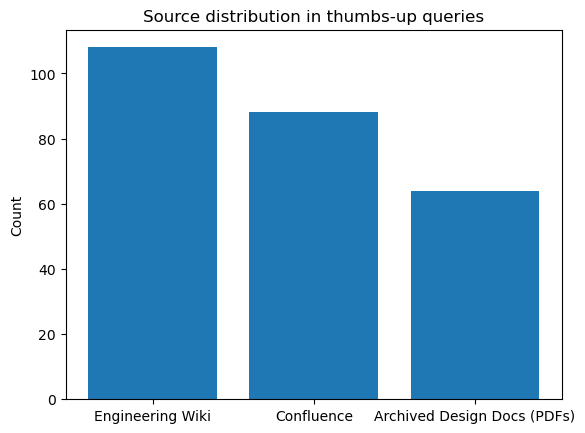

In [11]:
plt.bar(source_counts_up.keys(), source_counts_up.values())
plt.title("Source distribution in thumbs-up queries")
plt.ylabel("Count")
plt.show()

### Checking negative feedbacks

In [12]:
df_negative = df[df['user_feedback'] == 'thumb_down']

In [ ]:
all_sources_down = [source for sources_list in df_negative['sources'] for source in sources_list]
source_counts_down = Counter(all_sources_down)
print(source_counts_down)

Counter({'Archived Design Docs (PDFs)': 25, 'Confluence': 20, 'Engineering Wiki': 19})


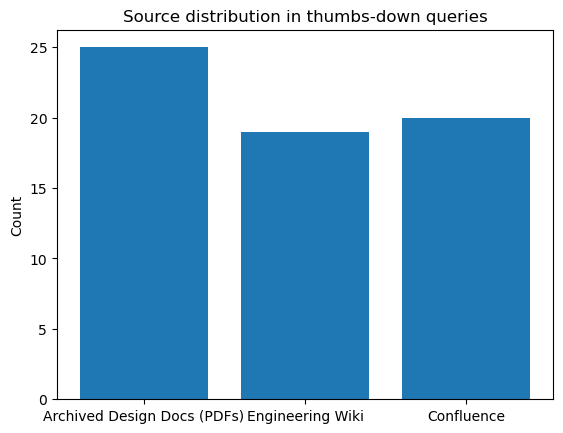

In [14]:
plt.bar(source_counts_down.keys(), source_counts_down.values())
plt.title("Source distribution in thumbs-down queries")
plt.ylabel("Count")
plt.show()

In [15]:
df_negative_summary = df_negative[['user_query', 'sources', 'response_latency_ms']]
df_negative_summary.sort_values(by = ['response_latency_ms'], inplace=True, ascending=False)
df_negative_summary.head(10)

/var/folders/vm/2yblxfx968b5fnxwrvwcklgc0000gn/T/ipykernel_29679/115483912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative_summary.sort_values(by = ['response_latency_ms'], inplace=True, ascending=False)


,user_query,sources,response_latency_ms
36,What is the plan for migrating from Python 2 t...,"[Archived Design Docs (PDFs), Engineering Wiki...",4950
68,What is the company's policy on using personal...,"[Archived Design Docs (PDFs), Engineering Wiki...",4900
41,What is our cloud provider's SLA for virtual m...,"[Archived Design Docs (PDFs), Engineering Wiki...",4700
44,What is the company's social media policy?,"[Archived Design Docs (PDFs), Confluence, Engi...",4400
33,What is the company's stance on remote work?,"[Archived Design Docs (PDFs), Confluence, Engi...",4350
78,What is the company's policy on employee educa...,"[Archived Design Docs (PDFs), Engineering Wiki...",4250
23,What is the company's travel and expense polic...,"[Archived Design Docs (PDFs), Confluence, Arch...",4200
11,What are the performance benchmarks for the ne...,"[Archived Design Docs (PDFs), Confluence, Arch...",4150
14,What is the company's policy on open source so...,"[Archived Design Docs (PDFs), Engineering Wiki...",3900
20,What version of Java is approved for new backe...,"[Engineering Wiki, Archived Design Docs (PDFs)...",3650


### Checking the latency issue

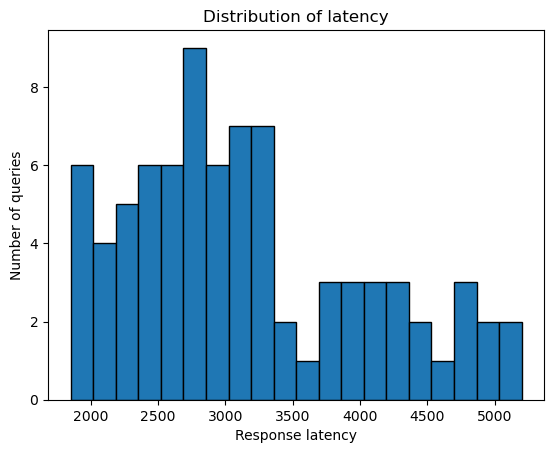

Queries above 3.5s: 23 / 81 (28.40%)


In [16]:
plt.hist(df['response_latency_ms'], bins=20, edgecolor='black')
plt.xlabel('Response latency')
plt.ylabel('Number of queries')
plt.title('Distribution of latency')
plt.show()


slow_count = (df['response_latency_ms'] > 3500).sum()
total_count = len(df)
print(f"Queries above 3.5s: {slow_count} / {total_count} ({slow_count / total_count:.2%})")

In [17]:
df_slow = df[df['response_latency_ms'] > 3500]
df_slow[['user_query', 'response_latency_ms', 'sources']]

,user_query,response_latency_ms,sources
3,Give me a complete summary of all key architec...,4850,"[Archived Design Docs (PDFs), Engineering Wiki..."
7,Summarize the key findings from the 2021 user ...,5100,"[Archived Design Docs (PDFs), Archived Design ..."
11,What are the performance benchmarks for the ne...,4150,"[Archived Design Docs (PDFs), Confluence, Arch..."
14,What is the company's policy on open source so...,3900,"[Archived Design Docs (PDFs), Engineering Wiki..."
18,What is the process for deprecating an API end...,3800,"[Engineering Wiki, Archived Design Docs (PDFs)..."
20,What version of Java is approved for new backe...,3650,"[Engineering Wiki, Archived Design Docs (PDFs)..."
23,What is the company's travel and expense polic...,4200,"[Archived Design Docs (PDFs), Confluence, Arch..."
28,What is the disaster recovery plan for the mai...,4500,"[Archived Design Docs (PDFs), Engineering Wiki..."
33,What is the company's stance on remote work?,4350,"[Archived Design Docs (PDFs), Confluence, Engi..."
36,What is the plan for migrating from Python 2 t...,4950,"[Archived Design Docs (PDFs), Engineering Wiki..."


Late responses mainly have PDf as the first source